In [1]:
from mvgavg import mvgavg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import glob
import skimage
import pandas as pd

path = "E:/Experimental_data/DREAM_microscope/"
exp = "2023-10-10_11_57_Oscillation_Protocol/"
list_output = glob.glob(path + exp + "*output*")
list_time = glob.glob(path + exp + "*time*")

output = pd.read_csv(list_output[0])


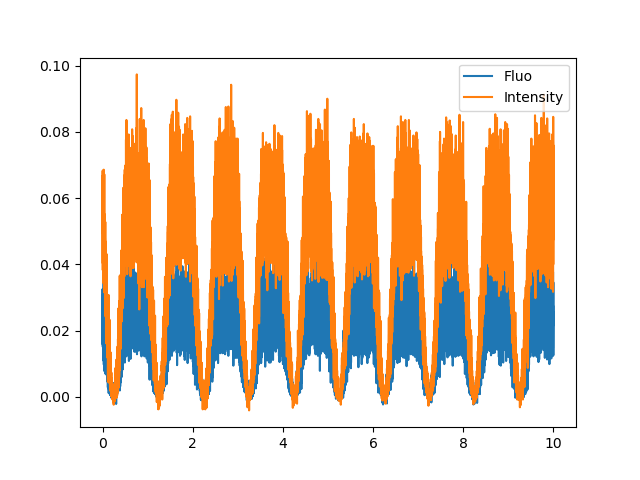

In [9]:
fig, ax = plt.subplots()
ax.plot(output["time"], output["Fluo"], label="Fluo")
ax.plot(output["time"], output["Intensity"], label="Intensity")
ax.legend()


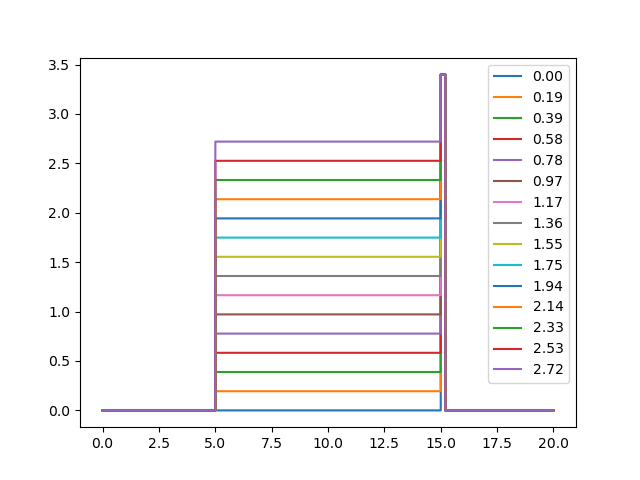

In [8]:
#LED
sat = 3.4 #V
duration_sat = 0.2 #ms 
start = 5
stop = 15

writing_rate =  1000 #Hz
acq_time = 20 #s
writing_samples = int(acq_time*writing_rate)

def fitness_sequence(offset, sat, start, stop, duration_sat):
    

    sample = np.linspace(0, acq_time, num = writing_samples , endpoint=False)
    actinic = np.zeros(sample.shape)
    actinic[start*writing_rate:stop*writing_rate] = offset
    pulse = np.zeros(sample.shape)
    pulse[stop*writing_rate:stop*writing_rate + int(duration_sat*writing_rate)] = sat

    signal = pulse + actinic

    return sample, signal

all_outputs = []
all_times = [] 
offsets = np.linspace(0, 0.8*sat, 15)

fig, ax = plt.subplots()

for i in offsets:
    sample, signal = fitness_sequence(i, sat, start, stop, duration_sat)
    all_outputs.append(signal)
    all_times.append(sample)

    ax.plot(sample, signal, label = f"{i:.2f}")
    ax.legend()





